# Project 1: Pose Graph Optimization (scratch + g2o)
TEAM-ID: 18    
TEAM-NAME: french-biriyani       
YOUR-ID:     2018112004 

YOUR-NAME:     Dipanwita Guhathakurta

(Although you work in groups, both the students have to submit to Moodle, hence there's name field above)

### Submission
Zip a folder of the following:
1. Files that you were provided with: `Project-1.ipynb`, the folders `misc` and `dataset`. Rest of the files asked in the questions below must be generated when i run the code. If generation of any file is computationally intensive, add `filename_backup.extension` where `filename.extension` is the expected name of file when i run the code. (For example, next point.)
2. Add `opt_backup.g2o` (described below) in outermost directory. Here, `opt.g2o` is the expected name of the file when I run the code.
3. For images of any results (like plots), save it in `./misc` folder.

On Moodle, all you have to submit is the jupyter notebook. But make sure to call the necessary functions explicitly (as specified in the notebook). The name of the zipped file being submitted to Moodle Assignment portal MUST BE `ID_Teamname_Firstname`. More details [here](https://www.notion.so/saishubodh/Course-Information-4c9e487b118547b2ba91d24e0dcaf04e#f2707a04f2a0446bac77763b47ba4bac).

On GitHub classrooms, the latest commit before the deadline will be considered as the submission. 

The deadline is Oct 16, 23:55 IST. Please get started ASAP, there is no way you can finish this project during the last few days before the deadline.

### General instructions

This ipython notebook (`.ipynb`) on GitHub is self-sufficient and has all the information you need to get started with the assignment, you don't need any corresponding PDF doc. Just fire up the notebook and get going!

General information like installation instructions in supplementary notebook "Project-1_Code-Walkthrough". Please take a look at it before you start this assignment.

Whenever I mention some `func()` below, I am referring to the "helper functions" in another supplementary notebook "Project-1_Code-Walkthrough" provided to you. Whenever I ask you to insert image below, it is better to save the image in `misc` and load it using `![file_name](file_location)` instead of directly pasting.    

[[CP-]] refers to CheckPoint, you have to ensure you do the tasks at each of the [[CP-]] places below. Not ensuring [[CP-B]] (CheckPoint-Basic) will incur heavy penalty and potentially 0 for that sub-section, and [[CP-M]] (CheckPoint-Marks) has a particular mark weightage depending on your results at that particular CP.

If you face any issues related to coding/installation, please raise an [issue here](https://github.com/Shubodh/MR-project1-pgo/issues). For any conceptual doubts, you can ask on Moodle or Teams as usual.

# 0. Introduction

In this project, we are going to use a non-linear weighted least squares optimization approach to solve the problem of getting a better estimate of our robot's trajectory. Least squares formulations are widely used for optimization, be it computer vision or robotics or machine learning. We will dive deep into it during this project and you will have complete clarity on optimization for vector-valued residual functions. 

In this "Introduction" section, I am going to provide an introduction for SLAM problem for a robot operating in the 2D world. It is 2. section in this Project. The 1D SLAM problem (1.) is far much simpler to understand and will be described directly in the 1. section. 

In a 2D world, a robot has 3 degrees of freedom, i.e. its pose in the world can be expressed by the state vector $\mathbf{x}=(x, y, \theta)^{\mathrm{T}}$. For the scope of this project, we are interested only in the robot's trajectory through the $2 \mathrm{D}$ world, and NOT in distinct landmarks or the surronding map of the environment, i.e. we are only interested in "L"ocalization part of SLAM. 

Therefore, we can represent it as a graph where the vertices represent robot poses $\mathbf{x}_{i}$ and edges represent the spatial constraints between these poses. Such a map is generally called a pose graph.

Two different kinds of constraints are necessary for pose graph SLAM. The first are
odometric constraints that connect two successive states $\mathbf{x}_{i}$ and $\mathbf{x}_{i+1}$ via a motion model. Furthermore, in order to perform loop closing, the robot has to recognize places it already visited before. This place recognition is also a part of the front-end and provides the second type of constraint, the loop closure constraints. These constraints connect two not necessarily successive poses $\mathbf{x}_{i}$ and $\mathbf{x}_{j}$.


![SLAM-trajectory-lc.png](misc/SLAM-trajectory-lc.png)   ![SLAM-trajectory-robust.png](misc/SLAM-trajectory-robust.png) (Source: [Sunderhauf 2012](https://core.ac.uk/download/pdf/89299995.pdf))

You will start from the inaccurate pose graph with odometry and loop closure information and by the end of this Project, you end up with an optimized pose graph (see above images) which should look close to ground truth trajectory. You can watch [this video](https://youtu.be/saVZtgPyyJQ) to get an intuition for what we're about to do.

Okay, that's enough of theory. Let's get out hands dirty with the code!

In [1]:
import matplotlib.pyplot as plt
import math
import os
import jax.numpy as jnp #see supplementary notebook to see how to use this
from jax import jacfwd

# If you're `importing numpy as np` for debugging purposes, 
# while submitting, please remove 'import numpy' and replace all np's with jnp's.(more in supplementary notebook)

# 1. Pose Graph Optimization for 1D SLAM

A solved example for 1D SLAM which optimizes for pose variables using weighted least squares method (Gauss Newton) has been explained in the class. It has been made [available here](https://www.notion.so/saishubodh/Solved-Example-1D-SLAM-weighted-LS-Illustrating-Sparsity-in-SLAM-d8b45893843b4377b07b1d4aa1aab4de). Your first task is to code this from scratch. [[CP-M]]

For this section, you have to calculate Jacobian analytically yourself and use it. However, you can check how correct `jax`'s `jacobian`. Its usage is explained in the supplementary notebook.

In [2]:
##############################################################################
# TODO: Code for Section 1                                                   #
def fn(x_i,u_i):
    return x_i + u_i
u = [1.1, 1.0, 1.1, -2.7, 0.0]
u_gt = [1.0, 1.0, 1.0, -3.0, 0.0]
x = [0.0]
x_gt = [0.0]

# print(x)
# f = np.array([fn(x[0],u[0])-x[1], ])
def f(x):
    f = []
    for i in range(4):
        f.append((x[i]+u[i])-x[i+1])
    f.append(x[0]+ u[4] - x[4]) 
    f.append(x[0] - 0)
    f = jnp.array(f)
    return f
# print(f.shape)
# print(f.T @ f)
cov = jnp.array([
    [0.01, 0, 0, 0, 0, 0],
    [0, 0.01, 0, 0, 0, 0],
    [0, 0, 0.01, 0, 0, 0],
    [0, 0, 0, 0.01, 0, 0],
    [0, 0, 0, 0, 0.01, 0],
    [0, 0, 0, 0, 0, 0.001]
])
omega = jnp.linalg.inv(cov)
# print(omega)
J = jnp.array([
    [1, -1, 0, 0, 0],
    [0, 1, -1, 0, 0],
    [0, 0, 1, -1, 0],
    [0, 0, 0, 1, -1],
    [1, 0, 0, 0, -1],
    [1, 0, 0, 0, 0]
]) # this will be the same for all instances since f() is defined in the same way at all times

def run_optimizer(J,omega,x):
    H = J.T @ omega @ J
    for i in range(5):
        ff = f(x)
        b = J.T @ omega.T @ ff
        del_x = -1 * jnp.linalg.inv(H) @ b
        x = jnp.array(x) + del_x
        print("The " + str(i+1) + "th" + " optimized position is:")
        print(x, "\n")


print ("Using analytically calculated Jacobian:\n")
for i in range(len(u)-1):
    x.append(fn(x[i], u[i]))
    x_gt.append(fn(x_gt[i], u_gt[i]))
print (x)
x0 = jnp.array(x)
run_optimizer(J,omega,x)
print ("Using jax's Jacobian:\n")
f_new = lambda x: f(x) 
J_new = jacfwd(f_new) #J doesn't change with change in x as f is linear w.r.t each element of x
J1 = J_new(x0)
# print (J1)
run_optimizer(J1,omega,x0)
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

/home/susiejojo/.local/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


Using analytically calculated Jacobian:

[0.0, 1.1, 2.1, 3.2, 0.5]
The 1th optimized position is:
[-1.6298145e-09  1.0000000e+00  1.8999999e+00  2.9000001e+00
  9.9999994e-02] 

The 2th optimized position is:
[3.5762859e-10 1.0000000e+00 1.9000000e+00 2.9000001e+00 1.0000003e-01] 

The 3th optimized position is:
[-2.0861607e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
  1.0000000e-01] 

The 4th optimized position is:
[-3.2782632e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
  1.0000000e-01] 

The 5th optimized position is:
[-3.2782613e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
  1.0000000e-01] 

Using jax's Jacobian:

The 1th optimized position is:
[-1.6298145e-09  1.0000001e+00  1.9000000e+00  2.8999999e+00
  9.9999934e-02] 

The 2th optimized position is:
[-3.5762593e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
  9.9999979e-02] 

The 3th optimized position is:
[-6.5565198e-10  1.0000000e+00  1.9000000e+00  2.9000001e+00
  9.9999994e-02] 

The 4th optimized position i

# 2. Pose Graph Optimization for 2D SLAM

Things are about to get interesting!

## 2.1 Coding from scratch

### Objective
A robot is travelling in a oval trajectory. It is equipped with wheel odometry for odometry information and RGBD sensors for loop closure information. Due to noise in wheel odometry it generates a noisy estimate of the trajectory. Our task is to use loop closure pairs to correct the drift.

We pose this problem as a graph optimization problem. In our graph, poses are the vertices and constraints are the edges. 

### Given: 
In practical scenarios, we'd obtain the following from our sensors after some post-processing:
1. Initial position
2. Odometry Contraints/Edges: This "edge" information basically tells us relative transformation between two nodes. These two nodes are consecutive in the case of Odometry but not in the case of Loop Closure (next point).
3. Loop Closure Contraints/Edges
Remember that while optimizing, you have another kind of "anchor" edge as you've seen in 1. solved example.

You have been given a text file named `edges.txt` which has all the above 3 and it follows G2O's format (as explained in class, [link here](https://www.notion.so/saishubodh/G2O-Edge-Description-fa07cc28967541dc8a71170de46c5da7) ).

### Details:
1. Using the following motion model, you have to first generate the "initialization" for all the poses/vertices using the "Given" information. Just like in the 1D case.
$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

Even the loop closure nodes are related by the above model, except that it need not necessarily be consecutive notes k and k+1.

Save this initial trajectory as `edges-poses.g2o`.

If you plot the initialized poses using odometry information, you need to get as the right plot [[CP-M]] below (this is the "noisy trajectory"): (Left one is the ground truth)
![robot-poses-MR-P1.png](./misc/robot-poses-MR-P1.png)
(Use `draw()` helper function or `g2o_viewer` or `EVO`)

2. Now calculate the residual and the Jacobian and update your parameters using LM.

Use LM algorithm. Regarding Jacobian calculation, you can use `jax`'s `jacobian` as part of your main code. However, you still have to separately calculate it analytically and verify if it matches with `jax`'s `jacobian` using [[CP-M]] frobenius norm `frobNorm()`). Calculation and verification is compulsory, but it is your choice to use whichever as part of your optimization. Use whichever is faster.

3. Regarding LM iterations, stopping criterion, information matrix values.

    1. [[CP-B]] As your iterations proceed, you have to print relevant information (iteration number and error value: [$F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ (notion page link)](https://www.notion.so/saishubodh/From-linear-algebra-to-non-linear-weighted-least-squares-optimization-13cf17d318be4d45bb8577c4d3ea4a02#32832dee7d6c4ab49581463d9b784f21) at every step).
    
    2. [[CP-B]] You have to show the plots (ground truth, noisy & optimized: all 3 in a single plot) at every 10 steps or so.

    3. [[CP-M]] You could start with information values of 500 for odom edges, 700 for loop closure edges, 1000 for anchor edge (same for all dimensions). However, you have to _heavily_ experiment with these values. (Given that you somehow know loop closure information is way more reliable than odometry.). At the end of your experimentation, your error $F = \frac{1}{2}  \mathbf{f}^{\top} \mathbf{\Omega} \mathbf{f} $ should by < 40. Explain your experimentation in detail using tables/plots etc if necessary.
    
Do not worry if you're not getting a perfect trajectory. Our parametrization was oversimplified for the sake of this project. With that being said, it is possible to get the error down to < 40 and make it at least look like an oval shaped trajectory, even if it doesn't perfectly resemble the ground truth. However, using `g2o` (next section), you will be getting a close to ground truth trajectory.

139


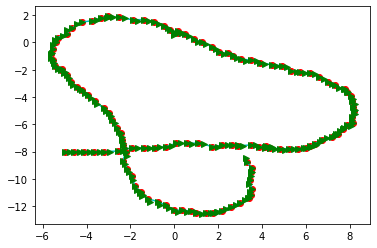

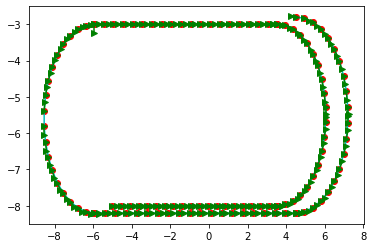

In [3]:
##############################################################################
# TODO: Code for Section 2.1                                                 #
def g2o_call(ip_file):
    cmd = "g2o -o edges_poses.g2o "+ip_file
    os.system(cmd)
    os.system("g2o_viewer edges_poses.g2o")
def readVertex(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    x_arr = []
    y_arr = []
    theta_arr = []

    for line in A:
        if "VERTEX_SE2" in line:
            (ver, ind, x, y, theta) = line.split()
            x_arr.append(float(x))
            y_arr.append(float(y))
            theta_arr.append(float(theta.rstrip('\n')))

    return jnp.array([x_arr, y_arr, theta_arr])

def readEdge(fileName):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()

    ind1_arr = []
    ind2_arr = []
    del_x = []
    del_y = []
    del_theta = []

    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            ind1_arr.append(int(ind1))
            ind2_arr.append(int(ind2))
            del_x.append(float(dx))
            del_y.append(float(dy))
            del_theta.append(float(dtheta))
    return (jnp.array(ind1_arr), jnp.array(ind2_arr), jnp.array(del_x), jnp.array(del_y), jnp.array(del_theta))

def find_edges(X,Y,THETA):
    L = len(X)-1;
    dx = jnp.zeros((L,1))
    dy = jnp.zeros((L,1))
    dtheta = jnp.zeros((L,1))
    for k in range(L):
        del_x = X[k+1]-X[k]
        del_y = Y[k+1]-Y[k]
        del_theta = THETA[k+1]-THETA[k]
        val_dx = del_x*jnp.cos(THETA[k])+del_y*jnp.sin(THETA[k])
        val_dy = -del_x*jnp.sin(THETA[k])+del_y*jnp.cos(THETA[k])
        dx = jax.ops.index_update(dx,jax.ops.index[k],val_dx)
        dy = jax.ops.index_update(dy,jax.ops.index[k],val_dy)
        dtheta = jax.ops.index_update(dtheta,jax.ops.index[k],del_theta)
    return dx,dy,dtheta

def writeVertex(i,x,y,theta,targetfile):
    f = open(targetfile, 'a')
    vert_str = "VERTEX_SE2 "+str(i)+" "+str(x)+" "+str(y)+" "+str(theta)+"\n"
    f.write(vert_str)
    f.close()
    
def writeInitialEdges(fileName,targetfile):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()
    f1 = open(targetfile, 'a')

    for line in A:
        if "EDGE_SE2" in line or "FIX" in line:
            f1.write(line)
    f1.close()
    
def writeEdges(fileName,targetfile,dx1,dy1,dth1):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()
    f1 = open(targetfile, 'a')
    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, a, b, c, d, e, f) = line.split()
            if (int(ind2)-int(ind1)==1):
                edge_str = "EDGE_SE2 "+str(ind1)+" "+str(ind2)+" "+str(dx1[int(ind1)][0])+" "+str(dy1[int(ind1)][0])+" "+str(dth1[int(ind1)][0])+" "+str(a)+" "+str(b)+" "+str(c)+" "+str(d)+" "+str(e)+" "+str(f)+"\n"
                f1.write(edge_str)
                
def draw(X, Y, THETA):
    ax = plt.subplot(111)
    ax.plot(X, Y, 'ro')
    plt.plot(X, Y, 'c-')

    for i in range(len(THETA)):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'g->')

    plt.show()
def plot_graphs(X,Y,THETA,X_gt,Y_gt,THETA_gt,X_init,Y_init,THETA_init):
    ax = plt.subplot(111)
    ax.plot(X_gt, Y_gt, 'bo',label='_nolegend_')
    plt.plot(X_gt, Y_gt, 'm-',label='_nolegend_')
    for i in range(len(THETA_gt)-1):
        x2 = 0.25*math.cos(THETA_gt[i]) + X_gt[i]
        y2 = 0.25*math.sin(THETA_gt[i]) + Y_gt[i]
        plt.plot([X_gt[i], x2], [Y_gt[i], y2], 'y->',label='_nolegend_')
    x2 = 0.25*math.cos(THETA_gt[len(THETA_gt)-1]) + X_gt[len(THETA_gt)-1]
    y2 = 0.25*math.sin(THETA_gt[len(THETA_gt)-1]) + Y_gt[len(THETA_gt)-1]
    plt.plot([X_gt[len(THETA_gt)-1], x2], [Y_gt[len(THETA_gt)-1], y2], 'y->')
    
    ax.plot(X_init, Y_init, 'bo',label='_nolegend_')
    plt.plot(X_init, Y_init, 'k-',label='_nolegend_')
    for i in range(len(THETA_init)-1):
        x2 = 0.25*math.cos(THETA_init[i]) + X_init[i]
        y2 = 0.25*math.sin(THETA_init[i]) + Y_init[i]
        plt.plot([X_init[i], x2], [Y_init[i], y2], 'g->',label='_nolegend_')
    x2 = 0.25*math.cos(THETA_init[len(THETA_init)-1]) + X_init[len(THETA_init)-1]
    y2 = 0.25*math.sin(THETA_init[len(THETA_init)-1]) + Y_init[len(THETA_init)-1]
    plt.plot([X_init[len(THETA_init)-1], x2], [Y_init[len(THETA_init)-1], y2], 'g->')
    
    ax.plot(X, Y, 'ko',label='_nolegend_')
    plt.plot(X, Y, 'c-',label='_nolegend_')
    for i in range(len(THETA)-1):
        x2 = 0.25*math.cos(THETA[i]) + X[i]
        y2 = 0.25*math.sin(THETA[i]) + Y[i]
        plt.plot([X[i], x2], [Y[i], y2], 'r->',label='_nolegend_')
    x2 = 0.25*math.cos(THETA[len(THETA)-1]) + X[len(THETA)-1]
    y2 = 0.25*math.sin(THETA[len(THETA)-1]) + Y[len(THETA)-1]
    plt.plot([X[len(THETA)-1], x2], [Y[len(THETA)-1], y2], 'r->')
    
    plt.legend(["Ground Truth","Noisy","Optimized"])
    plt.show()
def initial_vals(fileName,a,b,X,Y,THETA):
    f = open(fileName, 'r')
    A = f.readlines()
    f.close()
    x = 0
    y = 0
    theta = 0
    for line in A:
        if "EDGE_SE2" in line:
            (edge, ind1, ind2, dx, dy, dtheta, _, _, _, _, _, _) = line.split()
            if (int(ind1)==a and int(ind2)==b):
                x = X[a] + float(dx)*jnp.cos(THETA[a]) - float(dy)*jnp.sin(THETA[a])
                y = Y[a] + float(dy)*jnp.cos(THETA[a]) + float(dx)*jnp.sin(THETA[a])
                theta= THETA[a] + float(dtheta)
                break
    return x,y,theta

x0,y0,theta0 = readVertex("dataset/edges.g2o")
# print (v)
X_gt,Y_gt,THETA_gt = readVertex("dataset/gt.g2o")
i_ind,j_ind,dx,dy,dth =  readEdge("dataset/edges.g2o")
X_init = []
Y_init = []
THETA_init = []
X_init.append(x0)
Y_init.append(y0)
THETA_init.append(theta0)
# print (v_net)
n = len(i_ind)
print (n)
for i in range(n):
    x_new,y_new,theta_new = initial_vals("dataset/edges.g2o",i_ind[i],j_ind[i],X_init,Y_init,THETA_init)
    X_init.append(x_new)
    Y_init.append(y_new)
    THETA_init.append(theta_new)
    if (i<120):
        writeVertex(i,x_new[0],y_new[0],theta_new[0],"edges-poses.g2o")
writeInitialEdges("dataset/edges.g2o","edges-poses.g2o")
X_init = jnp.array(X_init)
Y_init = jnp.array(Y_init)
THETA_init = jnp.array(THETA_init)
draw(X_init[:-20],Y_init[:-20],THETA_init[:-20])
draw(X_gt,Y_gt,THETA_gt)

##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

### With info values 500,700,1000

**Note:**

Computationally intensive code. EVO trajectory displayed in external window after every 10 iterations and the window needs to be exited after viewing the trajectory after 10 iters. The reqd.values are printed, and the optimized trajectory, the ground truth and noisy trajectory are plotted along with displaying the error. Make sure you quit the EVO external window for the optimisation process to resume after every 10 iterations.

In [5]:
import jax
weights= jnp.vstack((jnp.ones((n-20,1))*500,jnp.ones((20,1))*700))
weights = jnp.vstack((weights,jnp.array([1000])))
weights = jnp.vstack((weights,(jnp.ones((n-20,1))*500)))
weights = jnp.vstack((weights,jnp.ones((20,1))*700))
weights = jnp.vstack((weights,jnp.array([1000])))
weights = jnp.vstack((weights,(jnp.ones((n-20,1))*500)))
weights = jnp.vstack((weights,jnp.ones((20,1))*700))
weights = jnp.vstack((weights,jnp.array([1000])))                  
omega = jnp.multiply(weights.T,jnp.eye(420))
    
def opt_vals(i_ind,j_ind,P,dx,dy,dth):
    X = P[:120]
    Y = P[120:240]
    THETA = P[240:]
    xopt = jnp.zeros((len(j_ind)+1,1))
    yopt = jnp.zeros((len(j_ind)+1,1))
    thopt = jnp.zeros((len(j_ind)+1,1))
#     print (X[0])
    xopt[0] = X[0]
    yopt[0] = Y[0]
    thopt[0] = THETA[0]
    for k in range(len(j_ind)):
        xopt[k+1] = X[i_ind[k]] + float(dx[k])*jnp.cos(THETA[i_ind[k]]) - float(dy[k])*jnp.sin(THETA[i_ind[k]])
        yopt[k+1] = Y[i_ind[k]] + float(dy[k])*jnp.cos(THETA[i_ind[k]]) + float(dx[k])*jnp.sin(THETA[i_ind[k]])
        thopt[k+1]= THETA[i_ind[k]] + float(dth[k])
    return xopt,yopt,thopt

def form_J(x,y,theta):
    J = jnp.zeros((420,360))
    for i in range(len(i_ind)):
        x_theta = -dx[i]*jnp.sin(theta[i_ind[i]])-dy[i]*jnp.cos(theta[i_ind[i]])
        J = jax.ops.index_update(J,jax.ops.index[i,i_ind[i]],1)
        J = jax.ops.index_update(J,jax.ops.index[i,j_ind[i]],-1)
        J = jax.ops.index_update(J,jax.ops.index[i,i_ind[i]+240],x_theta.item())
#         J[i][i_ind[i]] = 1
#         J[i][j_ind[i]] = -1
#         J[i][i_ind[i]+240] = -dx[i]*jnp.sin(theta[i_ind[i]])-dy[i]*jnp.cos(theta[i_ind[i]])
    J = jax.ops.index_update(J,jax.ops.index[139,0],1)
#     J[139][0] = 1
    for j in range(len(i_ind)):
        y_theta = -dy[j]*jnp.sin(theta[i_ind[j]])+dx[j]*jnp.cos(theta[i_ind[j]])
        J = jax.ops.index_update(J,jax.ops.index[j+140,i_ind[j]+120],1)
        J = jax.ops.index_update(J,jax.ops.index[j+140,j_ind[j]+120],-1)
        J = jax.ops.index_update(J,jax.ops.index[j+140,i_ind[j]+240],y_theta.item())
#         J[j+140][i_ind[j]+120] = 1
#         J[j+140][j_ind[j]+120] = -1
#         J[j+140][i_ind[j]+240] = -dy[j]*jnp.sin(theta[i_ind[j]])+dx[j]*jnp.cos(theta[i_ind[j]])
    J = jax.ops.index_update(J,jax.ops.index[279,120],1)
#     J[279][120] = 1
    for j in range(len(i_ind)):
        J = jax.ops.index_update(J,jax.ops.index[j+280,i_ind[j]+240],1)
        J = jax.ops.index_update(J,jax.ops.index[j+280,j_ind[j]+240],-1)
#         J[j+280][i_ind[j]+240] = 1
#         J[j+280][j_ind[j]+240] = -1
    J = jax.ops.index_update(J,jax.ops.index[419,240],1)
#     J[419][240] = 1
    return J
    
def fX_new(X):
    f = []
    x = X[:120]
    y = X[120:240]
    theta = X[240:]
    for k in range(n):
        x_new = x[i_ind[k]] + float(dx[k])*jnp.cos(theta[i_ind[k]]) - float(dy[k])*jnp.sin(theta[i_ind[k]])-x[j_ind[k]]
        f.append(x_new)
    x_end = x[0] + 5
    f.append(x_end)
    for k in range(n):
        y_new = y[i_ind[k]] + float(dy[k])*jnp.cos(theta[i_ind[k]]) + float(dx[k])*jnp.sin(theta[i_ind[k]])-y[j_ind[k]]
        f.append(y_new)
    y_end = y[0] + 8
    f.append(y_end)
    for k in range(n):
        theta_new = theta[i_ind[k]] + float(dth[k]) - theta[j_ind[k]]
        f.append(theta_new)
    th_end = theta[0] - 0
    f.append(th_end)
    f = jnp.array(f)
    f = f.reshape((-1, 1))
#     print (f)
    return f

def frobNorm(P1, P2, str1="mat1", str2="mat2"):
    jnp.set_printoptions(suppress=True)
    val = jnp.linalg.norm(P1 - P2, 'fro')
    print(f"Frobenius norm between {str1} and {str2} is: {val}")
    
def run_optimizer(omega,x,y,theta,lambd,num_iter,tol):
    n = 0
    cost_list = []
    while (n<num_iter):
        J = form_J(x,y,theta)
        params_prev1 = jnp.vstack((y,theta))
        params_prev = jnp.vstack((x,params_prev1))
#         J = jnp.asarray(J).reshape(420,360)
#         print ("J: ",J)
        x0 = params_prev
        f_new = lambda l: fX_new(l)
        J_new = jacfwd(f_new)
        J_1 = J_new(x0)
        J_1=J_1.reshape(420,360)
        H = J_1.T @ omega @ J_1
#         JI = jnp.eye(H.shape[0],H.shape[1])
#         for p in range(H.shape[0]):
#             jax.ops.index_update(JI,jax.ops.index[p,p],H[p,p])
#         H = H + lambd*JI
        
        H = H + lambd*jnp.multiply(H.diagonal().T,jnp.identity(len(H)))
#         print (H)
        ff = fX_new(params_prev)
        b = J_1.T @ omega.T @ ff
        cost = 0.5* ff.T @ omega @ ff
        cost_prev = cost
        del_x = -jnp.linalg.inv(H) @ b
        params_new = params_prev+ del_x
#         print (J,J_1)
#         print (J_1.shape,jnp.asarray(J).shape)
#         xopt_new,yopt_new,thopt_new = opt_vals(i_ind,j_ind,params_new,dx,dy,dth)
        ff_new = fX_new(params_new)
        cost_new = 0.5* ff_new.T @ omega @ ff_new
        if (cost_new<cost_prev):
            lambd = lambd/10
            x = params_new[:120]
            y = params_new[120:240]
            theta = params_new[240:]
            cost = cost_new
        else:
#             print ("Nah")
            lambd = lambd*10
        n+=1
        if (n<10 and n%4==0):
            print (frobNorm(J,J_1,"Calculated J","Jax's Jacobian"))
            print ("Error: ",cost_prev," for iter #",n)
            plot_graphs(x,y,theta,X_gt,Y_gt,THETA_gt,X_init[:120],Y_init[:120],THETA_init[:120])
        if (n%10==0 or n==(num_iter-1) or n==1):
            print (frobNorm(J,J_1,"Calculated J","Jax's Jacobian"))
            print ("Error: ",cost_prev," for iter #",n)
            os.system("rm opt.g2o")
            for i in range(x.shape[0]):
                writeVertex(i,x[i][0],y[i][0],theta[i][0],"opt.g2o")
            dx_new,dy_new,dth_new = find_edges(x,y,theta)
            writeEdges("dataset/edges.g2o","opt.g2o",dx_new,dy_new,dth_new)
            os.system("python misc/g2o_to_kitti.py dataset/gt.g2o gt.kitti")
            os.system("python misc/g2o_to_kitti.py opt.g2o opt.kitti")
            os.system("evo_traj kitti gt.kitti opt.kitti -v --plot --plot_mode xy")
            plot_graphs(x,y,theta,X_gt,Y_gt,THETA_gt,X_init[:120],Y_init[:120],THETA_init[:120])
        
        if (jnp.linalg.norm(params_new-params_prev)<tol):
            break
#         print (x,y,theta)
    print (n)
    return x,y,theta

# Y_opt = run_optimizer(J,omega,jnp.asarray(Y[:-20]),0.01,30,1e-10)
# J_theta = 
# # print (X_opt)
# draw(X_opt,Y_opt,THETA[:-20])

In [ ]:
X,Y,THETA = run_optimizer(omega,X_init[:120],Y_init[:120],THETA_init[:120],0.01,100,1e-15)

### With info 10,500,700

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[456694.3]]  for iter # 1


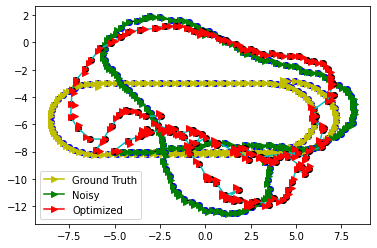

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[248.70535]]  for iter # 4


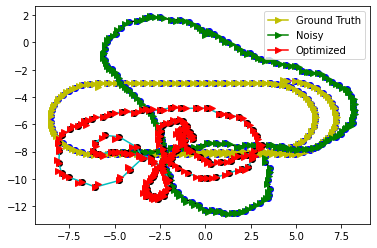

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[38.897385]]  for iter # 8


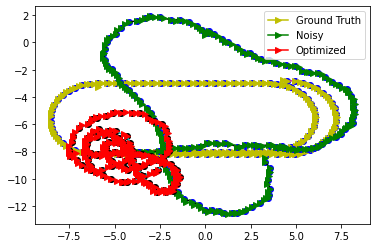

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[29.358997]]  for iter # 10


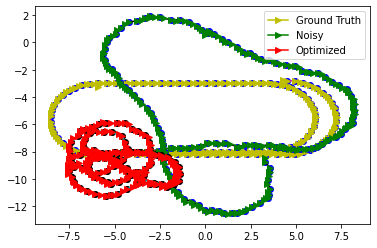

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[19.682247]]  for iter # 20


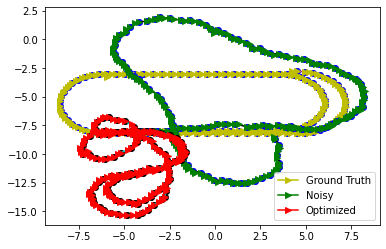

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[17.191994]]  for iter # 30


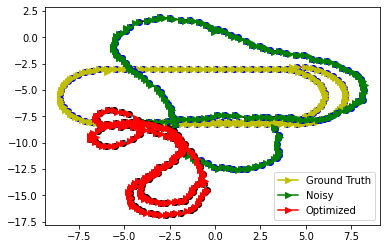

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[15.704595]]  for iter # 40


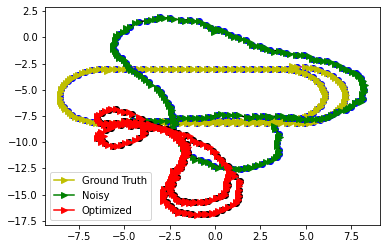

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[14.614347]]  for iter # 50


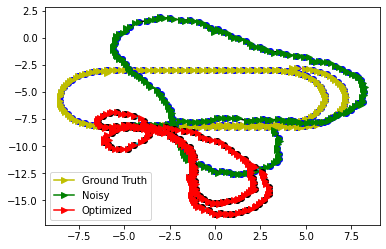

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[13.732246]]  for iter # 60


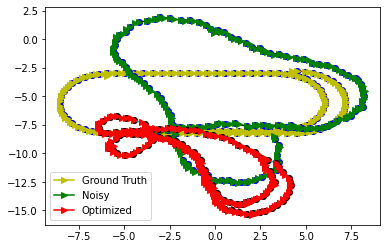

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[12.997204]]  for iter # 70


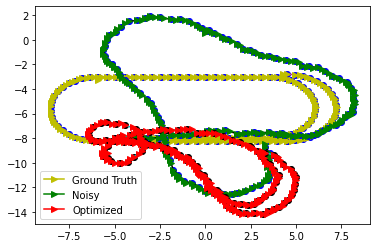

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[12.381873]]  for iter # 80


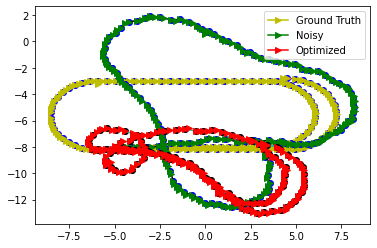

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[11.868036]]  for iter # 90


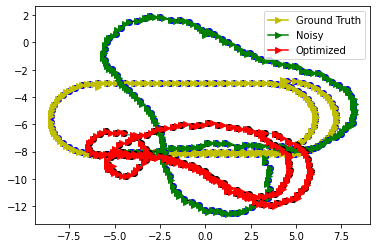

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[11.441316]]  for iter # 100


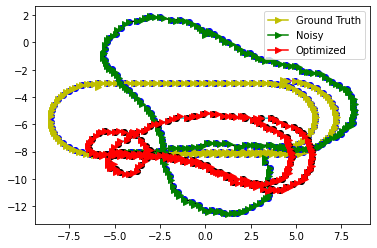

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[11.089287]]  for iter # 110


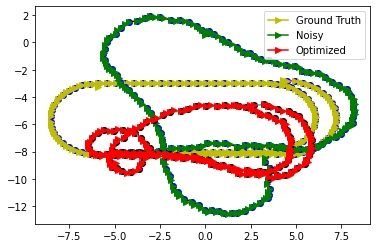

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[10.80083]]  for iter # 120


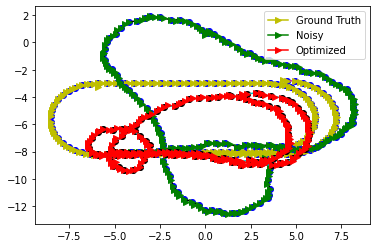

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[10.609154]]  for iter # 129


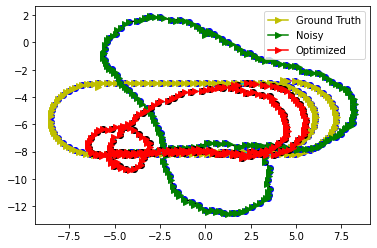

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[10.566054]]  for iter # 130


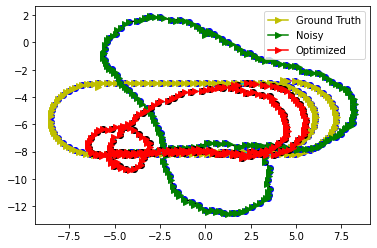

130


In [6]:
weights1= jnp.vstack((jnp.ones((n-20,1))*10,jnp.ones((20,1))*500))
weights1 = jnp.vstack((weights1,jnp.array([700])))
weights1 = jnp.vstack((weights1,(jnp.ones((n-20,1))*10)))
weights1 = jnp.vstack((weights1,jnp.ones((20,1))*500))
weights1 = jnp.vstack((weights1,jnp.array([700])))
weights1 = jnp.vstack((weights1,(jnp.ones((n-20,1))*10)))
weights1 = jnp.vstack((weights1,jnp.ones((20,1))*500))
weights1 = jnp.vstack((weights1,jnp.array([700])))                  
omega1 = jnp.multiply(weights1.T,jnp.eye(420))
X1,Y1,THETA1 = run_optimizer(omega1,X_init[:120],Y_init[:120],THETA_init[:120],0.01,130,1e-15)

### With info 200,500,700

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[456694.3]]  for iter # 1


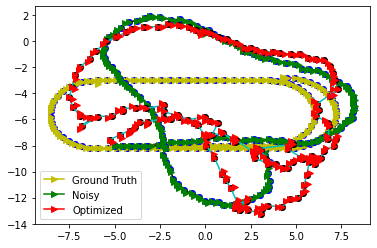

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[2735.8066]]  for iter # 4


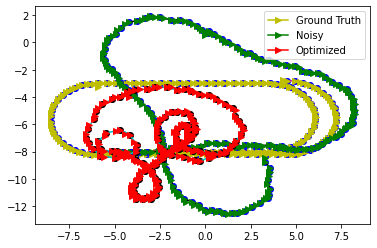

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[820.231]]  for iter # 8


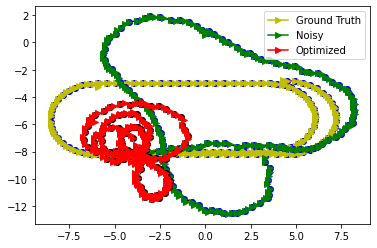

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[684.39844]]  for iter # 10


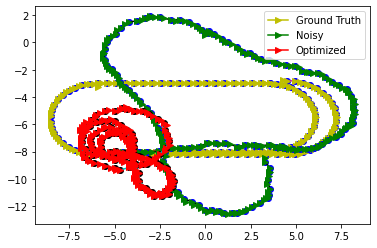

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[470.3397]]  for iter # 20


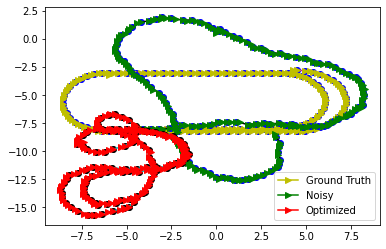

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[270.4879]]  for iter # 30


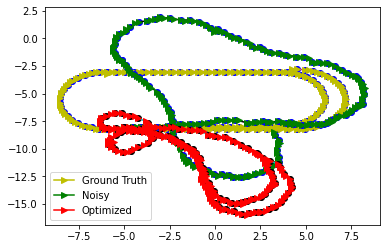

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[209.96141]]  for iter # 40


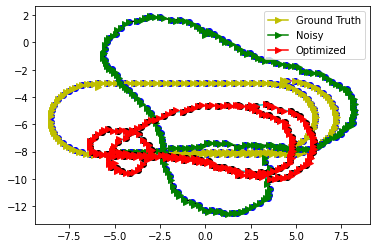

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[183.29036]]  for iter # 50


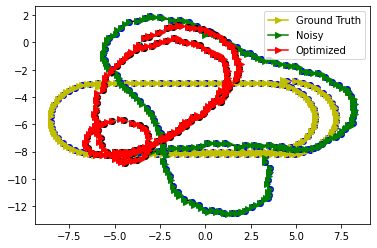

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[183.19394]]  for iter # 60


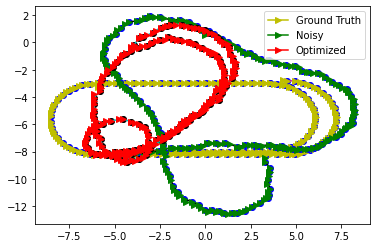

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[183.19394]]  for iter # 70


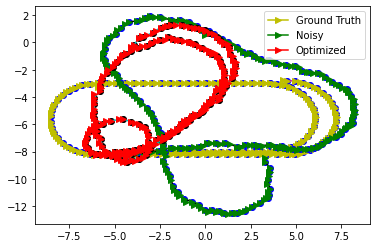

Frobenius norm between Calculated J and Jax's Jacobian is: 0.0
None
Error:  [[183.19394]]  for iter # 80


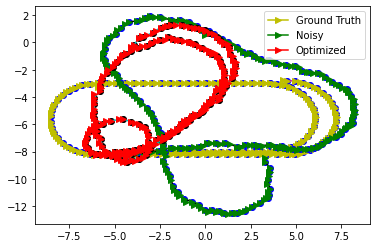

88


In [7]:
weights2= jnp.vstack((jnp.ones((n-20,1))*200,jnp.ones((20,1))*500))
weights2 = jnp.vstack((weights2,jnp.array([700])))
weights2 = jnp.vstack((weights2,(jnp.ones((n-20,1))*200)))
weights2 = jnp.vstack((weights2,jnp.ones((20,1))*500))
weights2 = jnp.vstack((weights2,jnp.array([700])))
weights2 = jnp.vstack((weights2,(jnp.ones((n-20,1))*200)))
weights2 = jnp.vstack((weights2,jnp.ones((20,1))*500))
weights2 = jnp.vstack((weights2,jnp.array([700])))                  
omega2 = jnp.multiply(weights2.T,jnp.eye(420))
X2,Y2,THETA2 = run_optimizer(omega2,X_init[:120],Y_init[:120],THETA_init[:120],0.01,140,1e-15)

### Final optimized trajectories in the above cases:

### For 500,700,1000

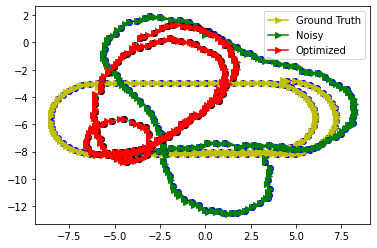

In [9]:
os.system("rm opt.g2o")
for i in range(X.shape[0]):
    writeVertex(i,X[i][0],Y[i][0],THETA[i][0],"opt.g2o")
opt_dx,opt_dy,opt_dth = find_edges(X,Y,THETA)
writeEdges("dataset/edges.g2o","opt.g2o",opt_dx,opt_dy,opt_dth)
plot_graphs(X,Y,THETA,X_gt,Y_gt,THETA_gt,X_init[:120],Y_init[:120],THETA_init[:120])

### For 10,500,700

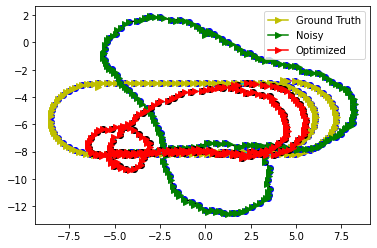

In [9]:
# os.system("rm misc/opt1.g2o")
for i in range(X1.shape[0]):
    writeVertex(i,X1[i][0],Y1[i][0],THETA1[i][0],"opt1.g2o")
opt_dx,opt_dy,opt_dth = find_edges(X1,Y1,THETA1)
writeEdges("dataset/edges.g2o","opt1.g2o",opt_dx,opt_dy,opt_dth)
plot_graphs(X1,Y1,THETA1,X_gt,Y_gt,THETA_gt,X_init[:120],Y_init[:120],THETA_init[:120])

### For 200,500,700

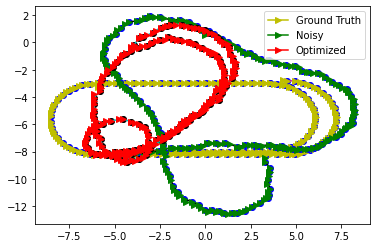

In [10]:
# os.system("rm misc/opt2.g2o")
for i in range(X2.shape[0]):
    writeVertex(i,X2[i][0],Y2[i][0],THETA2[i][0],"opt2.g2o")
opt_dx,opt_dy,opt_dth = find_edges(X2,Y2,THETA2)
writeEdges("dataset/edges.g2o","opt2.g2o",opt_dx,opt_dy,opt_dth)
plot_graphs(X2,Y2,THETA2,X_gt,Y_gt,THETA_gt,X_init[:120],Y_init[:120],THETA_init[:120])

## 2.1 Answer

Give a detailed answer addressing the above questions. When I run the above code, it should follow points described above (such as plots at every 10 steps) and (When I run the above code, it should) write the optimized poses to a file named `opt.g2o`. As a backup, save another file `opt_backup.g2o` in an offline manner beforehand.

That apart, save important plots and add them here so that it can supplement your answer, for example you could add plots at crucial stages of optimization. You have to add useful metrics/plots from `EVO` (refer to supplementary notebook). Using EVO, the bare minimum you have to report is `mean absolute pose error (ape)` and `mean relative pose error (rpe)`. However, you are encouraged to use tools like `evo_traj` and [more](https://github.com/MichaelGrupp/evo/#command-line-interface) and add more plots/metrics. Marks will be awarded based on overall analysis & presentation which would reflect your understanding.

Note that `EVO` and `g2o_viewer` (below) could help you in debugging.

### EVO outputs for info 500,700,1000

In [12]:
os.system("python misc/g2o_to_kitti.py dataset/gt.g2o gt.kitti")
os.system("python misc/g2o_to_kitti.py opt.g2o opt.kitti")
os.system("evo_rpe kitti gt.kitti opt.kitti -v --plot --plot_mode xy")
os.system("evo_ape kitti gt.kitti opt.kitti -v --plot --plot_mode xy")
os.system("evo_traj kitti gt.kitti opt.kitti -v --plot --plot_mode xy")

0

RPE w.r.t. translation part (m)
for delta = 1 (frames) using consecutive pairs
(not aligned)

       max	0.286835
      mean	0.116623
    median	0.108889
       min	0.006303
      rmse	0.132587
       sse	2.091950
       std	0.063075
--------------------------------------------------------------------------------
APE w.r.t. translation part (m)
(not aligned)

       max	10.090109
      mean	5.240147
    median	5.598720
       min	0.000000
      rmse	6.095289
       sse	4458.305766
       std	3.113424
--------------------------------------------------------------------------------
name:	gt
infos:

	nr. of poses	120
	path length (m)	52.976517997999295
	pos_end (m)	[-2.8 -4.5  0. ]
	pos_start (m)	[-8.  5.  0.]
--------------------------------------------------------------------------------
name:	opt
infos:

	nr. of poses	120
	path length (m)	53.77212243905029
	pos_end (m)	[-0.19046097  3.8750834   0.        ]
	pos_start (m)	[-8.  5.  0.]



### EVO outputs for info 10,500,700

In [11]:
os.system("python misc/g2o_to_kitti.py dataset/gt.g2o gt.kitti")
os.system("python misc/g2o_to_kitti.py opt1.g2o opt1.kitti")
os.system("evo_rpe kitti gt.kitti opt1.kitti -v --plot --plot_mode xy")
os.system("evo_ape kitti gt.kitti opt1.kitti -v --plot --plot_mode xy")
os.system("evo_traj kitti gt.kitti opt1.kitti -v --plot --plot_mode xy")

0

RPE w.r.t. translation part (m)
for delta = 1 (frames) using consecutive pairs
(not aligned)

       max	0.296654
      mean	0.117387
    median	0.112351
       min	0.010928
      rmse	0.132732
       sse	2.096530
       std	0.061953
--------------------------------------------------------------------------------
APE w.r.t. translation part (m)
(not aligned)

       max	6.772910
      mean	1.953010
    median	1.595805
       min	0.000347
      rmse	2.719954
       sse	887.777994
       std	1.893120
--------------------------------------------------------------------------------
name:	gt
infos:

	nr. of poses	120
	path length (m)	52.976517997999295
	pos_end (m)	[-2.8 -4.5  0. ]
	pos_start (m)	[-8.  5.  0.]
--------------------------------------------------------------------------------
name:	opt1
infos:

	nr. of poses	120
	path length (m)	53.67466588253421
	pos_end (m)	[-3.1187325 -1.797597   0.       ]
	pos_start (m)	[-8.000337  4.999918  0.      ]


### EVO outputs for info 200,500,700

In [12]:
os.system("python misc/g2o_to_kitti.py dataset/gt.g2o gt.kitti")
os.system("python misc/g2o_to_kitti.py opt2.g2o opt2.kitti")
os.system("evo_rpe kitti gt.kitti opt2.kitti -v --plot --plot_mode xy")
os.system("evo_ape kitti gt.kitti opt2.kitti -v --plot --plot_mode xy")
os.system("evo_traj kitti gt.kitti opt2.kitti -v --plot --plot_mode xy")

0

RPE w.r.t. translation part (m)
for delta = 1 (frames) using consecutive pairs
(not aligned)

       max	0.286906
      mean	0.116642
    median	0.113920
       min	0.006024
      rmse	0.132188
       sse	2.079367
       std	0.062195
--------------------------------------------------------------------------------
APE w.r.t. translation part (m)
(not aligned)

       max	10.151611
      mean	5.270521
    median	5.615299
       min	0.000000
      rmse	6.133018
       sse	4513.668967
       std	3.136163
--------------------------------------------------------------------------------
name:	gt
infos:

	nr. of poses	120
	path length (m)	52.976517997999295
	pos_end (m)	[-2.8 -4.5  0. ]
	pos_start (m)	[-8.  5.  0.]
--------------------------------------------------------------------------------
name:	opt2
infos:

	nr. of poses	120
	path length (m)	53.76395127256726
	pos_end (m)	[-0.17437017  3.9343538   0.        ]
	pos_start (m)	[-8.  5.  0.]


### Comparison of outputs for different info matrices

Info values          |  Final error  |  Mean RPE | Mean APE | No. of iterations | EVO_RPE | EVO_APE| EVO_Trajectory
:-------------------------:|:-------------------------:| :-------------------------|
500,700,1000   |   444.57623 |  0.116623 | 5.240147 | 81 | ![rp1](misc/rpe_500_700_1000.png) | ![ap1](misc/ape_500_700_1000.png) | ![t1](misc/traj_500_700_1000.png)
10,500,700     |   10.566054  | 0.117387 | 1.953010 | 130 |![rp2](misc/rpe_10_500_700.png) | ![ap2](misc/ape_10_500_700.png) | ![t2](misc/traj_10_500_700.png)
200,500,700     |   183.19394  | 0.116642 | 5.270521 | 88 |![rp2](misc/rpe_200_500_700.png) | ![ap2](misc/ape_200_500_700.png) | ![t2](misc/traj_200_500_700.png)

Add answer for 2.1 here:

## 2.2 Using g2o's optimization: g2o binary or g2o viewer 

Installation setup is described in supplementary notebook. More details for 2.2.1 and 2.2.2 can be found in the supplementary notebook.

### 2.2.1 Optimizing `edges.txt`
First task is to optimize the poses of dataset you've been working with so far.

### 2.2.2 Optimizing `intel` and `sphere` datasets
You have been given two datasets in the `data` folder. You have to use `g2o_viewer` to optimize these both. You have to experiment with the options/parameters available in the GUI. More instructions in supplementary notebook. You have to experiment till you get the trajectories which look like the following:

<table><tr>
<td> <img src="./misc/intel.jpg" alt="Drawing" style="width: 250px;"/> </td>
<td> <img src="./misc/sphere.jpg" alt="Drawing" style="width: 250px;"/> </td>
</tr></table>

In [13]:
os.system("g2o -o edges_gopt.g2o dataset/edges.g2o")
os.system("g2o_viewer dataset/edges.g2o")

0

In [14]:
os.system("g2o -o intel_gopt.g2o dataset/intel.g2o")
os.system("g2o_viewer dataset/intel.g2o")

0

In [15]:
os.system("g2o -o sphere_gopt.g2o dataset/sphere.g2o")
os.system("g2o_viewer dataset/sphere.g2o")

0

## 2.2 Answer

Add images: take screenshot of the GUI of `g2o_viewer` after optimization for all 3 [[CP-M]] and add here. Briefly describe what you had to do (detailed answer is not expected). g2o could potentially give you close to ground truth trajectory for all 3, but if you are unable to get to close to ground truth, add the best you can get.

## Result for edges.g2o

Optimizer          |  No. of iterations to converge  |  Kernel | Kernel Width
:-------------------------:|:-------------------------:| :-------------------------|
lm_fix3_2cholmod   |   11 | Nil | NA |
gn_fix3_2cholmod   |   149 | Nil | NA |
gn_var             |   149 | Nil | NA|
lm_var             |    13 | Nil | NA|
lm_fix3_2cholmod   |    88 | Cauchy | 1.0 |
lm_fix3_2cholmod   |   942 | Huber  | 1.0|
lm_var_eigen       |    13 | Nil    | NA

### Output:
<img src="misc/traj_lm_fix3_2cholmod.png" alt="drawing"/>


## Result for intel.g2o

Optimizer          |  No. of iterations to converge  |  Kernel | Kernel Width
:-------------------------:|:-------------------------:| :-------------------------|
lm_fix3_2cholmod   |   639 | Nil | NA |
gn_fix3_2cholmod   |   >1000 | Nil | NA |
gn_var             |   >1000 | Nil | NA|
lm_var             |    631 | Nil | NA|
lm_fix3_2cholmod   |    574 | Cauchy | 1.0 |
lm_fix3_2cholmod   |   3003 | Huber  | 1.0|
lm_var_eigen       |    635 | Nil    | NA

### Output:
<img src="misc/intel_g2o.png" alt="drawing"/>

## Results for sphere.g2o

Optimizer          |  No. of iterations to converge  |  Kernel | Kernel Width
:-------------------------:|:-------------------------:| :-------------------------|
lm_fix6_3cholmod   |   53 | Nil | NA |
gn_fix6_3cholmod   |   >1000 | Nil | NA |
lm_fix6_3cholmod   |    849 | Cauchy | 1.0 |
lm_var_eigen       |    53 | Nil    | NA

![sphere](misc/sphere_g2o.png "Title")

###  * Important Information regarding Questions 3  & 4
Note that it is mandatory to attempt EITHER 3 OR 4, only one of it. If you attempt both, the question which you score more will be considered and the other as bonus question. 

It is encouraged for those into robotics/deep learning research to prefer 4 over 3.

# [Bonus*] 3. Deriving Motion model geometrically
\* -> read information above under section "Important Information regarding Questions 3  & 4"

 
The current robot state is as follows: ($i$ and $k$ are interchangably used below, sorry I am too lazy to edit now 😛)  
![robot-situation.png](./misc/robot-situation.png)

Can you derive the below equation using geometry? (Read on)

$$x_{k+1} = x_{k} + \Delta x_{(k,k+1)} \cos(\theta_k) - \Delta y_{(k,k+1)} \sin(\theta_k) \\
y_{k+1} = y_{k} + \Delta y_{(k,k+1)} \cos(\theta_k) + \Delta x_{(k,k+1)} \sin(\theta_k) \\
\theta_{k+1} = \theta_{k}+  \Delta \theta_{(k,k+1)} \tag{3}$$

In other words, we want to find $\delta$'s in terms of $\Delta$'s
$$\delta x = \Delta x \cos(\theta) - \Delta y \sin(\theta) \\
\delta y = \Delta y \cos(\theta) + \Delta x \sin(\theta) \tag{2}$$

where $\delta$'s are the updates in our motion model equation:
$$ x_{k+1} = x_{k} + \delta x \\
y_{k + 1} = y_k + \delta y \\
\theta_{k+1} = \theta_{k} + \delta \theta \tag{1}$$

Oh yes, $\theta$ is straightforward, i.e. $\delta \theta = \Delta \theta$ but why? 

Using geometry, you could just draw and insert a self-explanatory image as the answer to this question.

If you can derive it without using geometry purely using transform matrices/algebra, that is fine too. Whatever you're comfortable.

## 3. Answer

The goal is to have all our coordinates in the world frame, i.e., to have a global representation.

Let the world frame be represented by $X_w$, $Y_w$, the $k^{th}$ odometry frame be represented by $X_k$, $Y_k$ (since the readings are in the sensor frame).\
Let $(x_k, y_k)$ be the origin of the $k^{th}$ odometry frame in the world frame.\
Let $\theta_k$ be the angle that represents the orientation of the $k^{th}$ odometry frame with respect to the world frame, i.e., a rotation matrix in SO(2) can be described.\
Therefore,

$$\Delta x_{k,k+1} \text{: movement along } X_k \\ \Delta y_{k,k+1} \text{: movement along } Y_k \\ \Delta \theta_{k,k+1} \text{: change in the orientation as seen in the } k^{th} \text{ frame}$$

$$\delta x_{k,k+1} \text{: movement along } X_w \\ \delta y_{k,k+1} \text{: movement along } Y_w \\ \delta \theta_{k,k+1} \text{: change in the orientation as seen in the world frame}$$

![misc/q3.jpeg](./misc/q3.jpeg)

Note that since the rotations here are in the $x-y$ plane, i.e., along the $z$-axis (yaw), the rotation taking place in the world frame and the respective odometry frame is the same, or $\Delta \theta_{k,k+1} = \delta \theta_{k,k+1}$.

If
$$R^w_k = \begin{bmatrix}cos \theta_k & -sin \theta_k \\ sin \theta_k & cos \theta_k \end{bmatrix}$$ \
$$\Delta_k = \begin{bmatrix} \Delta x_{k,k+1} \\ \Delta y_{k,k+1} \end{bmatrix}$$ \
$$\delta_k = \begin{bmatrix} \delta x_{k,k+1} \\ \delta y_{k,k+1} \end{bmatrix}$$ \
then
$$\delta_k = R^w_k \Delta_k$$ \
$$\therefore \delta x_{k,k+1} = \Delta x_{k,k+1} cos \theta_k - \Delta x_{k,k+1} sin \theta_k \\ 
\therefore \delta y_{k,k+1} = \Delta x_{k,k+1} sin \theta_k + \Delta x_{k,k+1} cos \theta_k$$

Hence,
$$x_{k+1} = x_{k} + \delta x \\ y_{k+1} = y_k + \delta y \\ \theta_{k+1} = \theta_k + \delta \theta$$

# [Bonus*] 4. Research Paper Reading
\* -> read information above under section "Important Information regarding Questions 3  & 4"

(Do not get intimidated, you are not expected to do a thorough research analysis for this task. A high level understanding is sufficient.)


["Past, Present & Future of SLAM: Towards the Robust Perception Age"](https://arxiv.org/abs/1606.05830) is an exciting survey paper of 2016 which sums up, well, the "past, present & future" of SLAM. Your task is as follows:

1. Go through the sections "IV. LONG-TERM AUTONOMY II: SCALABILITY" & "III. LONG-TERM AUTONOMY I: ROBUSTNESS". Don't worry, you are not expected to have a deep understanding. Skip the parts which you don't understand at all. Go through it at a high level, and take a slightly closer look at "Open Problems" in these sections.

2. Read up common applications of deep learning for computer vision/robotics through blogs online (for example, first 4 points of [this](https://machinelearningmastery.com/applications-of-deep-learning-for-computer-vision/). Again, you are only expected to understand it at a high level, for example, 'semantic segmentation is an application of deep learning for computer vision which is the task of assigning a category to each of the pixels in the image'.

Firstly, summarize your understanding of the above two points.
   
Now, from the understanding you've gathered so far, how would you approach solving those "Open Problems"? 
Can these algorithms help in dealing with some of the issues you might have faced during this project? Can the deep learing based high level understanding of the world help in SLAM? In the context of long term autonomy, imagine tomorrow's world with a buddy robot R2-D2 which follows you wherever you go... Now imagine how easily the trajectory can diverge, how big the map could soon become and how the computation could easily become intractable.   

Answer the above questions in the context of this project and those 2 sections of the survey paper.

## 4. Answer

### Brief Summary of 1:

The SLAM problem involves 2 parts which have to be done simultaneously: 
* **Estimation of the state of a robot equipped with  on-board sensors (localisation)**

    Here we estimate the robot pose(position and orientation) along with some other parameters like sensor calibration etc.


* **Construction of the map of the environment that the sensors are perceiving (mapping)** 

 Constructing a representation of aspects of interest(e.g.,position of landmarks, obstacles) describing the environment in which the robot operates. The map not only helps in path planning, but also in reducing the error in estimating the robot state.
 
Broadly the SLAM problem is divided into 2 parts:

- **Frontend**:
 
Entirely sensor-dependent. Abstracts sensor data into models for estimation and extracts relevant features from sensor data, sends the data to the backend for processing. In computer vision applications, the frontend is entrusted with extracting the pixel location of few distinguishable points in the environment, in associating each measurement to a "landmark" via **data association** as well providing an initial guess for backend optimization. Typically the process of data association consists of 2 tasks: 
    *short-term block - associating corresponding features in consecutive sensor measurements, or say, consecutive frames
    *long-term block - associating new measurements to old landmarks.(e.g loop closure)

- **Backend**: 
 
Receives pre-processed sensor data from the frontend. Given a set of observations,robot states, prior factors, landmarks and loop closure constraints the SLAM backend constructs a **"factor-graph"** representation, for ease of visualisation and modelling complex problems. The sparsity of the factor graph aids in the optimisation process. Next given a set of beliefs Z, the SLAM backend estimates the likelihood of the measurements given the current beliefs, and uses **MAP** (Maximum Aposterori Estimate) or ML (Maximum Likelihood estimate), and then converts the probabilistic model into an optimisation problem by estimating the measurement noise as normally distributed Gaussian noise with a certain info matrix. This converts to a **non-linear least squares** formulation, which is solved by various iterative optimisation methods via successive linearisations such as Gauss Newton and Levenberg-Marquardt methods. The matrix appearing in the normal equations is sparse as   dictated by the topology of the underlying factor graph. This enables the use of fast linear solvers hat enables incremental or online computation of the SLAM problem. 

The SLAM backend also sends feedback to the SLAM frontend.

** Why is SLAM problem difficult? **

* Online computation of complex graph optimisation problems.
* SLAM frontend runs into **robustness** issues related to hardware, while both SLAM frontend and backend run into algorithmic challenges. 
* Sensor/Actuator degradation 
* Perceputual aliasing in data association - the  phenomenon  in  which  different  sensoryinputs lead to the same sensor signature
* Failure of optimizer to reach global minima
* Unmodeled dynamics in the environment(time-varying and deformable maps) - the static world assumption
* Harsh environments such as underwater etc.
* Lack of generalising to a large type of hardware
* Computational limitations
* Storage limitations
* Severe Illumination variations
* Hardware failure
* Scalability issues
 
 *Problems with data association:*
 
 Short-term: 
 
 Perceptual aliasing leads to false positives in measurement-state matches, while rejection of sensor data as false negatives leads to a loss of accuracy. This error is amplified as the erroneous data is sent to the backend.
 
 Long-term:
 
 Loop closure detection - Detecting and matching features obtained from the current set of observations against all prevoiusly registered features. Runs into issues with variances in illumination, need for better sequence-matching algorithms.
 
 Loop closure validation - Determining the quality of the loop closure detected. Wrong  loop  closures  can  severely corrupt the quality of the MAP estimate.
 
 *Dynamic environments:*
 
 The SLAM algorithm has to decide whether to keep, discard or track changes and model long-term and short-term changes. 
 
 *Scalability issues:*

    Continuous exploration of new places and the increasing time of operation, as well as the memory storage of the factor-graph formulation of the SLAM problems whose no. of nodes increases with each new observation. In practice, the computational time  and memory footprint are bounded by the resources of the robot.


 
** Efforts to solve the challenges associated with SLAM: **

* Tackling perceptual aliasing: by taking samples at a high rate which may be helpful for making a clearer map, as viewpoint doesn't change significantly over successive frames or observations.
* by using models like **Bag of Words** and Hierarchical vocabulary trees to map current features to previous features
* additional geometric verification steps to ascertain the quality of the loop closure.In vision-based applications, **RANSAC** is commonly used for geometric verification and outlier rejection.
* **Node  and  edge  sparsification:** One way is by making solution sparse, this can be done by reducing the number of nodes added to the graph, or by pruning less “informative” nodes and factors. Few solutions work in a way like **sparsifying** the Hessian matrix (which is computationally high) by solving an L1  -regularized minimization problem.
* **Continuous-time trajectory estimation:** Reducing the number of parameters few approaches are like representing the nodes in the factor graph as the control-points (knots) of the spline which were optimized in a sliding window fashion.
* **out-of-core and multi-robot methods**: 
**Submapping algorithms**, i.e, Parallel out-of-core algorithms for SLAM that split the computation load of graph optimization among multiple processors. These divide the factor graph into different subgraphs and optimize the overall graph by alternating local optimization of each subgraph, with a global refinement.
* **Distributed  multi  robot  SLAM**:
 Deploy multiple robots doing SLAM, and divide the scenario into smaller areas. In **centralised** approach, robots relay local info to a central station to derive inferences, and a **decentralised** approach, central  data fusion and the agents leverage local communication to reach consensus on a common map. 
 


### Brief Summary of 2:

Computer vision problems are shifting from a statistical approach to a deep learning based approach, notably in the following domains:
* **Image classification**
involves assigning a label to an entire image or photograph. Some examples of image classification include:
    * Labeling an x-ray as cancer or not (binary classification).
    * Classifying a handwritten digit (multiclass classification).
    * Assigning a name to a photograph of a face (multiclass classification).
    * Detection of plant species

* **Image Classification With Localization**
involves assigning a class label to an image and showing the location of the object in the image by a bounding box (drawing a box around the object).
Example: 
    * Labeling an x-ray as cancer or not and drawing a box around the cancerous region.
    * Classifying photographs of animals and drawing a box around the animal in each scene.
* **Object detection**  is the task of image classification with localization, although an image may contain multiple objects that require localization and classification. This may involve adding bounding boxes around multiple examples of the same object in the image. 
* **Facial recognition** involves identifying a specific face out of many given faces. This task is like image recognition but much more complex than recognition of objects.
* **Style transfer or neural style transfer** is the task of learning style from one or more images and applying that style to a new image.
* **Object segmentation** is the task of object detection but pixels in an image are segmented into different categories of object.
* **Image super-resolution** is the task of generating a new version of an image with a higher resolution and detail than the original image.
* **Image synthesis** is the task of generating targeted modifications of existing images or entirely new images.

These ideas can also be used in robotic vision for better results and can possibly resolve a lot of robustness issues associated with SLAM and similar applications.


### Open Problems:

As presented in the paper, some of the open problems in the field of SLAM and their possible solns are:

* *Failsafe SLAM and recovery*

SLAM systems need to be aware of imminent failure due to the outliers issue and  provide recovery mechanisms that can reestablish proper operation. To achieve this, we can possibly update the SLAM estimate not after every observation, but after a specific time-horizon. Further by employing techniques such as Reinforcement Learning, we can ensure that the SLAM outputs do not deviate too largely from their previous estimates and plan trajectories accordingly.

* *Hardware issues*

Hardware problems are not only limited to hardware failure, but because of sensor reading offsets, faulty calibration, processing data from multiple sensors. To deal with sensor reading offsets, we can place some more sensors to give a reading of the offset of sensor reading. For camera used as a sensor, we can eliminate illumination issues by using efficient filtering methods like Gabor Filter. Further we can save sensor data temporarily in a volatile memory to be used in case of unexpected sudden hardware failures.

* *Metric Relocalization*

It is the process of estimating the relative pose with respect to the previously built map. As proposed in the paper, mapping with one sensor modality (e.g.3Dlidar)and localizing in the same map with a different sensormodality(e.g., camera) can be a useful addition. Further, spatial information, inherent to the SLAM problem, such as trajectory matching, might be exploited to overcome these limitations.

* *Time  varying  and  deformable  maps*

One approach to solve this would be to equip the SLAM system with sensors of relatively high sampling rate, as is done in solving the short-term data association problem. For example, if a laser scanner scans the environment at a very high sampling rate, we can assume the environment remains relatively static for the span of that time. Further we can use some interpolation and planning techniques to relatively predict future changes in the environment, upon which the SLAM algorithm will expect certain changes in the environment and accordingly process at the frontend. A typical approach would be to use Kalman Filter to estimate specific parameters of the environment to increase the robustness of the SLAM system to dynamic environments. However this comes possibly at the expense of computational complexity.

* *Automatic parameter tuning:*

Extensive  parameter tuning is needed for SLAM in order to work correctly. These parameters include thresholds  that control feature matching, RANSAC parameters, and criteria to decide when to add newfactors to the graph or when to trigger a loop closing algorithm. This can be achieved by using efficient controller feedback mechanisms.

* *Map representation*

Raw representations as point clouds or volumetric maps are wasteful in terms of memory and storing feature  descriptors for vision-based SLAM is cumbersome. For this map compression techniques and map component hashing can be used instead. 

* *Learning, forgetting, remembering*

Problem regarding how often to update the information contained in the map and how to decide when this information becomes outdated and needs to be discarded. While updating at periodic intervals may not be a smart choice, the update span would be largely case and scenario dependent.

* *Robust  distributed  mapping*

In distributed mapping the robots may not share a common reference frame, it may be difficult for them to reach a common consensus regarding rejecting and keep loop closures. As suggested in the paper,robots can actively verify location hypotheses using a rendezvous strategy before fusing information. Probabilistic approaches can also be followed to establish a common reference frame in the face of spurious measurements.

* *Resource-constrained  platforms*

Running SLAM algorithms on severely constrained platforms such as Mobile phones, micro-aerial vehicles and so on presents a huge challenge as there is a tradeoff between accuracy of estimation against resource constraints(memory and computation, communication dropout, bandwidth constraints etc). Distributed mapping can aid in dividing the computational effort, but it comes with its own challenges as mentioned above.

## Employing Deep Learning to solve SLAM issues:

* **Solving the data association problem**:

In the data association problem one of the biggest challenges is in extracting notable features from the sensor data and identifying landmarks within the environment. The standard approach is to identify local features within the image by using algorithms like SIFT and SURF which compare the feature descriptors with that of a set of reference images. Instead we can use image segmentation algorithms to group pixels with similar attributes from the image or by using edge detection techniques to better analyse the environment images. We can also identify specific objects in the image by using object detection techniques with known shapes and based on position of the bounding boxes we can identify the object across multiple frames. 

* **Generating Failsafe trajectories**:

As mentioned above we can take feedback by using an Reinforcement Learning techniques to reward the robot or penalize it to follow a trajectory such that SLAM doesn't fail. 
The inspiration for this is derived from the following paper:
https://arxiv.org/abs/1607.07558.
This approach can also enable long-term autonomy as asked in the question about using R2-D2. 

Further another inspiration we derived from the following paper is by using Stereo camera to perform large-scale online SLAM computation.
https://jakobengel.github.io/pdf/engel2015_stereo_lsdslam.pdf

## In the context of the project:

By repeated experimentation we observed that if loop closure confidence and anchor constraints confidence is largely higher than that of the successive edges, we get lower error and better trajectory. Hence a large focus should be made on generating accurate loop closures. Another important factor we observed from the project is the fact that the robot model is very important in determining the accuracy of SLAM, since our modelling of the robot model is overly simplified, specially in the update of theta, hence even with low errors, our trajectories are not perfect or close to the original. This is because Euclidean update doesn't work in case of theta, plus theta is bounded between [-pi,pi], so we cannot use Gaussian for its error modelling. 

### Fun section
Check the end of your Project-1 homepage on Notion. :)